* Transformers - provides a function on data
* Datasets - takes a transformer and manages data
* Dataloader - takes data set and creates batches

In [21]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

# Interactive mode?
%matplotlib inline
plt.ion()

In [18]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix().astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


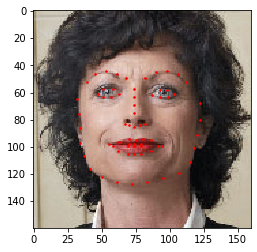

In [22]:
# Show data
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),landmarks)

plt.show()

In [23]:
# Custom dataset implementation
class FaceLandmarksDataset(Dataset):

    # Store data upon initialization
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # Implement len(dataset)
    def __len__(self):
        return len(self.landmarks_frame)

    # Implement dataset[i]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image data
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        # Get landmark data
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        # Apply transformation
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)

        # Return dictionary of
        return sample

0 (324, 215, 3) (68, 2)


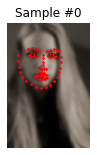

1 (500, 333, 3) (68, 2)


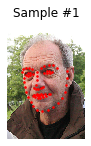

2 (250, 258, 3) (68, 2)


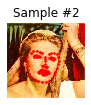

3 (434, 290, 3) (68, 2)


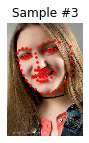

In [25]:
# Test dataset

# Initiate dataset
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',root_dir='data/faces/')
fig = plt.figure()

# Iterate through dataset
for i in range(len(face_dataset)):
    # Get sample
    sample = face_dataset[i]

    # Display sample
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    # End loop
    if i == 3:
        plt.show()
        break

In [26]:
# Transformers as classes
# __init__ - for initialization data
# __call__ - defines trans_obj(sample)


# Unifies size of the image
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}


# Crop image for data augmentation
class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,left: left + new_w]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}


# Convert to Tensor object
class ToTensor(object):

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

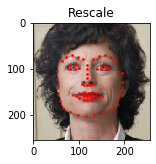

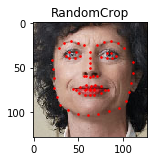

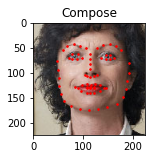

In [27]:
fig = plt.figure()
sample = face_dataset[65]

# Combine (or 'Compose') multiple transformations in a pipeline
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# Display transformations
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    # Display
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [33]:
# Helper function to show a batch

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


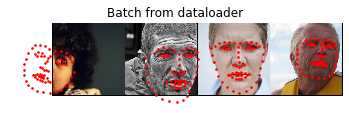

In [34]:
csv_f = 'data/faces/face_landmarks.csv'
r_d = 'data/faces/'

# Define transformers and dataset
transformers = transforms.Compose([Rescale(256),RandomCrop(224),ToTensor()])
dataset = FaceLandmarksDataset(csv_file=csv_f, root_dir=r_d, transform=transformers)

# Initiate dataloader
# - creates batches
# - support for parallel processing
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())

    # Stop
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break